In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
ratings = pd.read_csv("./ml-latest-small/ratings.csv")
ratings[ratings.userId==1].head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [3]:
movies = pd.read_csv('./ml-latest/movies.csv', encoding='latin-1')
print (movies.shape)
movies.head()

(58098, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
num_users = ratings.userId.unique().shape[0]
num_items = ratings.movieId.unique().shape[0]
num_users, num_items

(610, 9724)

In [5]:
from sklearn import model_selection as ms
train_set, test_set = ms.train_test_split(ratings, test_size=0.25)
len(train_set), len(test_set)

(75627, 25209)

In [6]:
user_movie_matrix = train_set.pivot(index='userId', columns='movieId', values='rating')
print("UM Matrix value size", user_movie_matrix.values.size)
print("ratings value size", ratings.values.size)
print("Sparisity: {:4.2f}%".format(ratings.rating.values.size/user_movie_matrix.values.size*100))
user_movie_matrix.head(10)

UM Matrix value size 5319810
ratings value size 403344
Sparisity: 1.90%


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,4.0,5.0,3.0,5.0,4.0,NaN,3.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# similarity
import math
from operator import itemgetter
from scipy.spatial import distance

def distance_cosine(a,b):
    return 1-distance.cosine(a,b)

def disance_corr(a,b):
    return 1-distance.correlation(a,b)

def distance_euclidean(a,b):
    return 1/(distance.euclidean(a,b)+1)

In [8]:
def nearest_neighbor_user(user, topN, simFunc) :  
    u1 = user_movie_matrix.loc[user].dropna()
    ratedIndex = u1.index
    nn = {}
    
    # Brute-Force Compute
    for uid, row in user_movie_matrix.iterrows():
        interSectionU1 = []
        interSectionU2 = []
        if uid==user:
            continue
            
        for i in ratedIndex:
            if False==math.isnan(row[i]):
                interSectionU1.append(u1[i])
                interSectionU2.append(row[i])
        interSectionLen = len(interSectionU1)
        
        # at least 3 intersection items
        if interSectionLen < 3 :
            continue
            
        # similarity functon
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[uid] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [9]:
def nearest_neighbor_item(movie, topN, simFunc):
    m1 = user_movie_matrix[movie].dropna()
    user_index = m1.index
    nn = {}
    
    for movieId, col in user_movie_matrix.iteritems():
        interSectionU1 = []
        interSectionU2 = []
        if movie == movieId:
            continue
        
        for i in user_index:
            if False==math.isnan(col[i]):
                interSectionU1.append(m1[i])
                interSectionU2.append(col[i])
        interSectionLen = len(interSectionU1)
        
        # at least 3 intersection items
        if interSectionLen < 3:
            continue
            
        # similarity functon
        sim = simFunc(interSectionU1, interSectionU2)
        
        if  math.isnan(sim) == False:
            nn[movieId] = sim
            
    # top N returned         
    return sorted(nn.items(),key=itemgetter(1),reverse=True)[:(topN+1)]

In [10]:
print(pd.DataFrame(nearest_neighbor_user(278, 100, distance_euclidean), columns=['userId', 'sim']).head())
print(pd.DataFrame(nearest_neighbor_item(1, 100, distance_euclidean), columns=['movieId', 'sim']).head())

   userId       sim
0      32  0.666667
1     226  0.666667
2     182  0.585786
3     216  0.585786
4     280  0.585786
   movieId  sim
0      373  1.0
1     1273  1.0
2     1484  1.0
3     2940  1.0
4     4745  1.0


In [11]:
def predictRating(id_num, nn=50, simFunc=distance_euclidean, kind = 'user') :
   
    if (kind == "user"):
        ## neighboorhood 
        neighbor = nearest_neighbor_user(id_num, nn, simFunc)

        neighbor_id = [id for id, sim in neighbor]
        # List of similar similarities

        ## Remove if two or more are NaN
        neighbor_movie = user_movie_matrix.loc[neighbor_id].dropna(1, how = 'all', thresh = 2)
        # User id x DataFrame of movie id. However, if the NaN of the column is 2 or more, it is deleted.

        neighbor_dic = dict(neighbor)
        ret = [] 
        #['movieId', 'predictedRate']

        # iterate through each column key: userid, column: movieid, value: rating
        for movieId, row in neighbor_movie.iteritems():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0],0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([movieId, wsum/jsum])

        return ret
    
    elif (kind == 'item'):
        neighbor = nearest_neighbor_item(id_num, nn, simFunc)
        
        neighbor_id = [id for id, sim in neighbor]
        
        neighbor_ratedUser = user_movie_matrix[neighbor_id].dropna(0, how = 'all', thresh = 2)
        
        neighbor_dic = dict(neighbor)
        ret = []
        
        for userId, row in neighbor_ratedUser.iterrows():
            jsum, wsum = 0, 0
            for v in row.dropna().iteritems():
                sim = neighbor_dic.get(v[0], 0)
                jsum += sim
                wsum += (v[1]*sim)
            ret.append([userId, wsum/jsum])
        
        return ret
        

In [12]:
# predictRating(1, 100, kind = 'user')
predictRating(1, 50, kind = 'item')

[[28, 3.173690740086821],
 [51, 4.5],
 [63, 4.815300968740935],
 [64, 4.25],
 [105, 4.0],
 [111, 4.021999371462563],
 [140, 3.1631546299565896],
 [156, 4.181332914308376],
 [182, 4.056408190228889],
 [186, 4.0],
 [199, 3.833333333333333],
 [226, 3.733855637236537],
 [245, 3.0],
 [249, 4.5],
 [250, 4.467711274473075],
 [274, 3.6495597372397177],
 [275, 5.0],
 [279, 3.0],
 [280, 4.266144362763463],
 [287, 3.610474079305436],
 [288, 4.0],
 [290, 4.0],
 [298, 3.0],
 [305, 3.6947629603472825],
 [313, 3.347381480173641],
 [318, 3.535201915770066],
 [325, 3.0],
 [330, 4.0],
 [332, 3.7499999999999996],
 [357, 5.0],
 [377, 3.75],
 [380, 5.0],
 [387, 3.25],
 [391, 3.0],
 [414, 3.9696043966046686],
 [438, 4.0],
 [448, 3.532288725526925],
 [465, 5.0],
 [474, 3.5368649516390263],
 [480, 3.266144362763463],
 [483, 3.9843606131073237],
 [484, 4.25],
 [504, 4.25],
 [509, 4.2],
 [514, 3.2499999999999996],
 [525, 3.8406664571541875],
 [534, 3.999999999999999],
 [590, 4.0],
 [597, 4.0],
 [599, 2.94514979

In [13]:
## view rated movies and movies with high ratings
def ratingMovies(user_id):
    ds = pd.merge(train_set[train_set.userId==user_id], movies, on=['movieId'])
    return ds.sort_values(by=['rating'], ascending=False)[['rating','title','genres','movieId']].head(100)
ratingMovies(1).head()

,rating,title,genres,movieId
94,5.0,"Game, The (1997)",Drama|Mystery|Thriller,1625
76,5.0,Highlander (1986),Action|Adventure|Fantasy,1275
88,5.0,Indiana Jones and the Temple of Doom (1984),Action|Adventure|Fantasy,2115
87,5.0,Basic Instinct (1992),Crime|Mystery|Thriller,1092
86,5.0,Full Metal Jacket (1987),Drama|War,1222


In [14]:
def join_movie_info(predicted_result, movie = 1, kind = 'user'):
    if (kind == 'user'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['movieId', 'predicted_rating'])
        result_ds = pd.merge(movies[movies.movieId > 0], predicted_ratings, on=['movieId'])
        return result_ds.sort_values(by=['predicted_rating'], ascending=False)
    
    elif (kind == 'item'):
        predicted_ratings = pd.DataFrame(predicted_result, columns=['userId', 'predicted_rating'])
        return predicted_ratings.sort_values(by=['predicted_rating'], ascending=False)
    
result_user = predictRating(50, kind = 'user') # prediction of user #50
result_item = predictRating(1, kind = 'item') # prediction of movie #1
join_movie_info(result_user, kind = 'user').head(10)

,movieId,title,genres,predicted_rating
202,1284,"Big Sleep, The (1946)",Crime|Film-Noir|Mystery,5.000000
206,1356,Star Trek: First Contact (1996),Action|Adventure|Sci-Fi|Thriller,5.000000
222,2324,Life Is Beautiful (La Vita Ã¨ bella) (1997),Comedy|Drama|Romance|War,5.000000
68,246,Hoop Dreams (1994),Documentary,5.000000
233,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.794165
195,1235,Harold and Maude (1971),Comedy|Drama|Romance,4.741646
190,1212,"Third Man, The (1949)",Film-Noir|Mystery|Thriller,4.728401
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4.713835
196,1247,"Graduate, The (1967)",Comedy|Drama|Romance,4.666909
198,1252,Chinatown (1974),Crime|Film-Noir|Mystery|Thriller,4.659856


In [15]:
join_movie_info(result_item, kind = 'item').head(10)

,userId,predicted_rating
29,357,5.000000
37,465,5.000000
31,380,5.000000
16,275,5.000000
53,610,4.860990
2,63,4.815301
1,51,4.500000
13,249,4.500000
14,250,4.467711
18,280,4.266144


In [16]:
# 5th user's star rating
userId=1
pd.merge(ratingMovies(userId), join_movie_info(predictRating(userId)), 
         on=['movieId'], how='right').sort_values(by=['predicted_rating'], ascending =False)

,rating,title_x,genres_x,movieId,title_y,genres_y,predicted_rating
25,NaN,NaN,NaN,608,Fargo (1996),Comedy|Crime|Drama|Thriller,5.000000
24,NaN,NaN,NaN,1221,"Godfather: Part II, The (1974)",Crime|Drama,5.000000
23,NaN,NaN,NaN,16,Casino (1995),Crime|Drama,5.000000
5,5.0,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,5.000000
29,NaN,NaN,NaN,4011,Snatch (2000),Comedy|Crime|Thriller,5.000000
28,NaN,NaN,NaN,58,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance,5.000000
27,NaN,NaN,NaN,6016,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,5.000000
26,NaN,NaN,NaN,3996,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",Action|Drama|Romance,5.000000
30,NaN,NaN,NaN,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,5.000000
31,NaN,NaN,NaN,5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy,5.000000


In [17]:
eval_ratings = test_set

def eval_prediction(predict, neighbors=50, kind = 'user'):
    if (kind == 'user'):
        ## evaluation
        ds = pd.merge(eval_ratings, test_set[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        user_distance_functions = [('user_euclidean',distance_euclidean), ('user_cosine', distance_cosine)]
        for name, func in user_distance_functions:
            ds[name] = 0
            for user_id in predict:
                # key: movie id, value : predicted_rating
                for x in predictRating(user_id, neighbors, func):
                    ds.loc[(ds.userId == user_id) & (ds.movieId == x[0]),name]=x[1]
        #Only the tuple corresponding to the user performing the predict in the entire dataFrame is returned
        return ds[ds.user_euclidean + ds.user_cosine > 0]

                    
    elif (kind == 'item'):
        ## evaluation
        ds = pd.merge(eval_ratings, test_set[['movieId','rating']].groupby(['movieId']).mean().reset_index(), 
                      on='movieId', how='left')

        ds = ds.rename(columns= {'rating_x':'rating', 'rating_y':'mean_rating'})
        st = time.time()
        ## udpate to predict_rating 
        item_distance_functions = [('item_euclidean', distance_euclidean), ('item_cosine', distance_cosine)]
        for name, func in item_distance_functions:
            ds[name] = 0
            for movie_id in predict:
                for x in predictRating(movie_id, neighbors, func, kind = 'item'):
                    ds.loc[(ds.movieId == movie_id) & (ds.userId == x[0]), name] = x[1]
        return ds[ds.item_euclidean + ds.item_cosine > 0]
    
    print('runtime', round(time.time()-st,2), 'sec')
    

In [18]:
## all userId list 
users = user_movie_matrix.index.tolist()
## 10-person star rating
predicted_user = eval_prediction(users[:5], 100, kind = 'user')

predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]

def RMSE(X, left_col, right_col):
    return(np.sqrt(np.mean((X[left_col] - X[right_col])**2)))

def MAE(X, left_col, right_col):
    return(np.mean(np.absolute(X[left_col] - X[right_col])) )

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("MAE of {0} is {1} ".format(name, MAE(predicted_user, 'rating', name)))

for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
    print ("RMSE of {0} is {1} ".format(name, RMSE(predicted_user, 'rating', name)))

MAE of mean_rating is 0.8487247145591069 
MAE of user_cosine is 0.9662757847472032 
MAE of user_euclidean is 0.958793178683581 
RMSE of mean_rating is 1.1819750553975719 
RMSE of user_cosine is 1.3268363502973877 
RMSE of user_euclidean is 1.3094200805738563 


In [19]:
users = user_movie_matrix.index.tolist()
predicted_item = eval_prediction(users[:5], 100, kind = 'item')
predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item MAE of {0} is {1} ".format(name, MAE(predicted_item, 'rating', name)))

for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
    print ("Item-item RMSE of {0} is {1} ".format(name, RMSE(predicted_item, 'rating', name)))

Item-item MAE of mean_rating is 0.881764763014763 
Item-item MAE of item_cosine is 0.8248053969335869 
Item-item MAE of item_euclidean is 0.7453867983970532 
Item-item RMSE of mean_rating is 1.16039118592183 
Item-item RMSE of item_cosine is 1.005548730327693 
Item-item RMSE of item_euclidean is 0.9264503453702889 


In [20]:
predicted_user

,userId,movieId,rating,timestamp,mean_rating,user_euclidean,user_cosine
339,4,595,3.0,986848609,3.750000,3.934280,4.268606
915,1,235,4.0,964980908,3.823529,4.000000,3.376105
1186,4,1197,5.0,964538763,4.236111,3.870645,4.173390
1578,4,1073,4.0,945079483,3.863636,3.302745,4.090914
1978,1,2542,5.0,964981265,4.400000,4.843399,4.800247
2075,1,223,3.0,964980985,4.152174,4.500000,4.416975
2110,1,2997,4.0,964980896,3.769231,4.250000,4.249566
3707,2,89774,5.0,1445715189,3.875000,3.813343,3.583021
3887,4,3175,1.0,964538930,3.615385,2.472694,3.810352
3942,5,349,3.0,847434832,3.597222,3.355601,3.599117


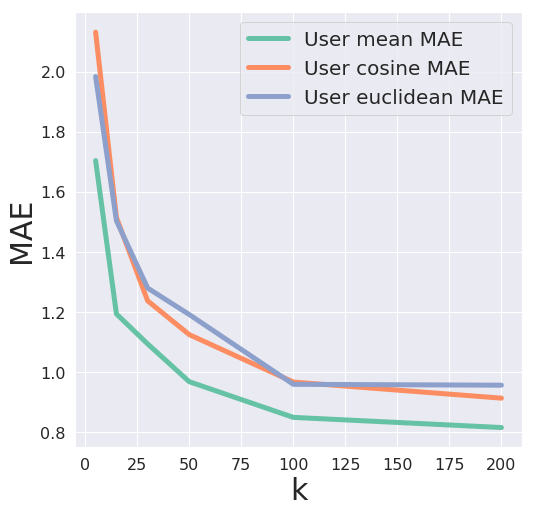

In [21]:
k_array = [5, 15, 30, 50, 100, 200]
user_mean_MAE = []
user_mean_RMSE = []
user_cosine_MAE = []
user_cosine_RMSE = []
user_euc_MAE = []
user_euc_RMSE = []

for k in k_array:
    predicted_user = eval_prediction(users[:5], k, kind = 'user')

    predicted_user = predicted_user[(predicted_user['user_cosine'] > 0) & (predicted_user['user_euclidean'] > 0)]
    
    for name in ['mean_rating', 'user_cosine', 'user_euclidean']:
        if (name == 'mean_rating'):
            user_mean_MAE.append(MAE(predicted_user, 'rating', name))
            user_mean_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_cosine'):
            user_cosine_MAE.append(MAE(predicted_user, 'rating', name))
            user_cosine_RMSE.append(RMSE(predicted_user, 'rating', name))
        elif (name == 'user_euclidean'):
            user_euc_MAE.append(MAE(predicted_user, 'rating', name))
            user_euc_RMSE.append(RMSE(predicted_user, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_MAE, c=pal[0], label='User mean MAE', linewidth=5)
plt.plot(k_array, user_cosine_MAE, c=pal[1], label='User cosine MAE', linewidth=5)
plt.plot(k_array, user_euc_MAE, c=pal[2], label='User euclidean MAE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

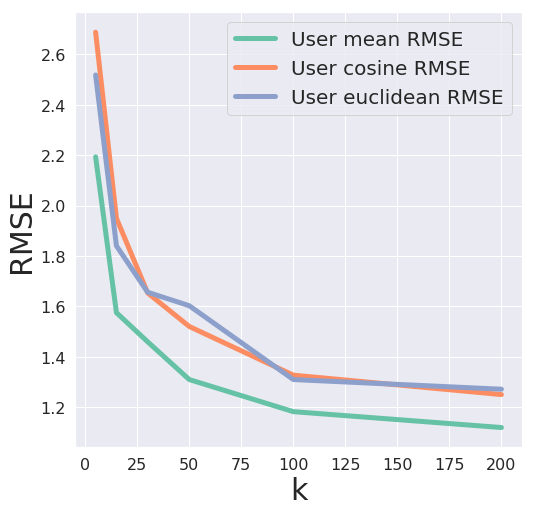

In [22]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, user_mean_RMSE, c=pal[0], label='User mean RMSE', linewidth=5)
plt.plot(k_array, user_cosine_RMSE, c=pal[1], label='User cosine RMSE', linewidth=5)
plt.plot(k_array, user_euc_RMSE, c=pal[2], label='User euclidean RMSE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);

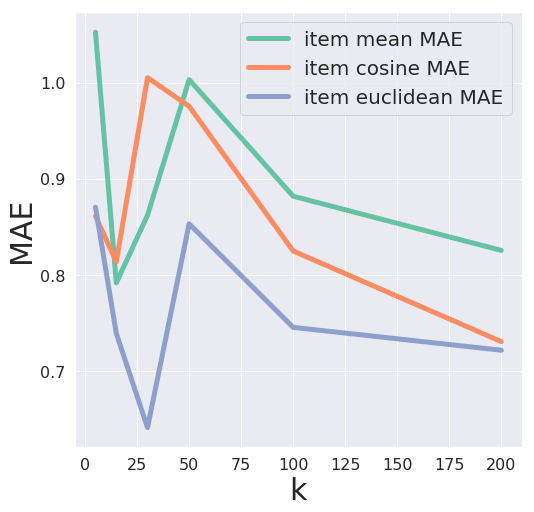

In [23]:
k_array = [5, 15, 30, 50, 100, 200]
item_mean_MAE = []
item_mean_RMSE = []
item_cosine_MAE = []
item_cosine_RMSE = []
item_euc_MAE = []
item_euc_RMSE = []

for k in k_array:
    predicted_item = eval_prediction(users[:5], k, kind = 'item')

    predicted_item = predicted_item[(predicted_item['item_cosine'] > 0) & (predicted_item['item_euclidean'] > 0)]
    
    for name in ['mean_rating', 'item_cosine', 'item_euclidean']:
        if (name == 'mean_rating'):
            item_mean_MAE.append(MAE(predicted_item, 'rating', name))
            item_mean_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_cosine'):
            item_cosine_MAE.append(MAE(predicted_item, 'rating', name))
            item_cosine_RMSE.append(RMSE(predicted_item, 'rating', name))
        elif (name == 'item_euclidean'):
            item_euc_MAE.append(MAE(predicted_item, 'rating', name))
            item_euc_RMSE.append(RMSE(predicted_item, 'rating', name))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_MAE, c=pal[0], label='item mean MAE', linewidth=5)
plt.plot(k_array, item_cosine_MAE, c=pal[1], label='item cosine MAE', linewidth=5)
plt.plot(k_array, item_euc_MAE, c=pal[2], label='item euclidean MAE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MAE', fontsize=30);

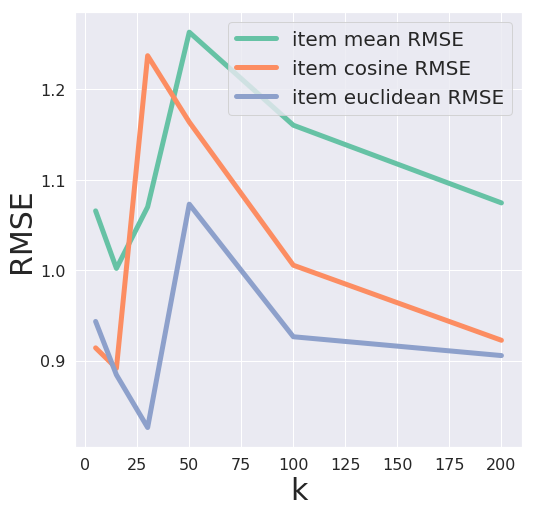

In [24]:
sns.set()

pal = sns.color_palette("Set2", 3)
plt.figure(figsize=(8, 8))
plt.plot(k_array, item_mean_RMSE, c=pal[0], label='item mean RMSE', linewidth=5)
plt.plot(k_array, item_cosine_RMSE, c=pal[1], label='item cosine RMSE', linewidth=5)
plt.plot(k_array, item_euc_RMSE, c=pal[2], label='item euclidean RMSE', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('RMSE', fontsize=30);